In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Aufgabe 1a

- Sample x values from the standard normal distribution for different values of N (the number of samples).
- Calculate the empirical mean for each N.
- Plot the empirical mean versus N to show the convergence towards the true mean, which is 0.

### This script uses the following steps:
- defines the true mean of the Gaussian distribution, which is 0.
- creates a range of sample sizes N using a logarithmic scale to get a good spread from small to large values.
- For each sample size N, it generates N samples from the standard normal distribution, computes the empirical mean of these samples, and stores the result.
- It plots the empirical means versus the sample sizes, showing how the approximation improves as N increases.
- Running this script will generate a plot that shows the empirical mean converging to the true mean (0) as the number of samples N increases. The convergence should become apparent as the plot will show fluctuations around the true mean for small N and increasingly stable values as N grows larger.

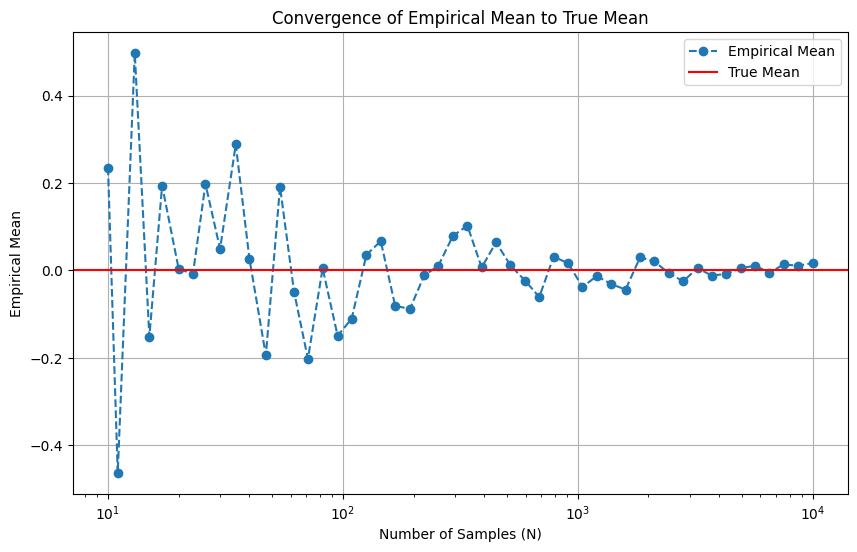

In [3]:
# Define the true mean of the Gaussian distribution
true_mean = 0

# List of different sample sizes to consider
sample_sizes = np.logspace(1, 4, num=50, dtype=int)

# Store the empirical means
empirical_means = []

# Perform the sampling and compute empirical means
for N in sample_sizes:
    samples = np.random.normal(loc=0, scale=1, size=N)
    empirical_mean = np.mean(samples)
    empirical_means.append(empirical_mean)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, empirical_means, label='Empirical Mean', marker='o', linestyle='--')
plt.axhline(y=true_mean, color='r', linestyle='-', label='True Mean')
plt.xscale('log')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Empirical Mean')
plt.title('Convergence of Empirical Mean to True Mean')
plt.legend()
plt.grid(True)
plt.show()

# Aufgabe 1b)

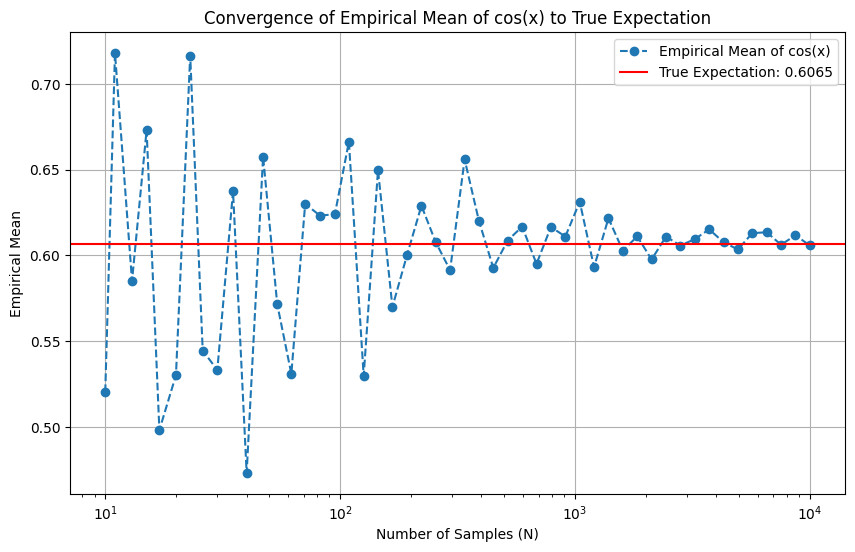

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# True expectation value
sigma = 1
true_expectation = np.exp(-sigma**2 / 2)

# List of different sample sizes to consider
sample_sizes = np.logspace(1, 4, num=50, dtype=int)

# Store the empirical means
empirical_means = []

# Perform the sampling and compute empirical means
for N in sample_sizes:
    samples = np.random.normal(loc=0, scale=sigma, size=N)
    empirical_mean = np.mean(np.cos(samples))
    empirical_means.append(empirical_mean)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, empirical_means, label='Empirical Mean of cos(x)', marker='o', linestyle='--')
plt.axhline(y=true_expectation, color='r', linestyle='-', label=f'True Expectation: {true_expectation:.4f}')
plt.xscale('log')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Empirical Mean')
plt.title('Convergence of Empirical Mean of cos(x) to True Expectation')
plt.legend()
plt.grid(True)
plt.show()


Aufgabe 2b

Sample Mean: 1.9746843987690883
Theoretical Mean: 2.0


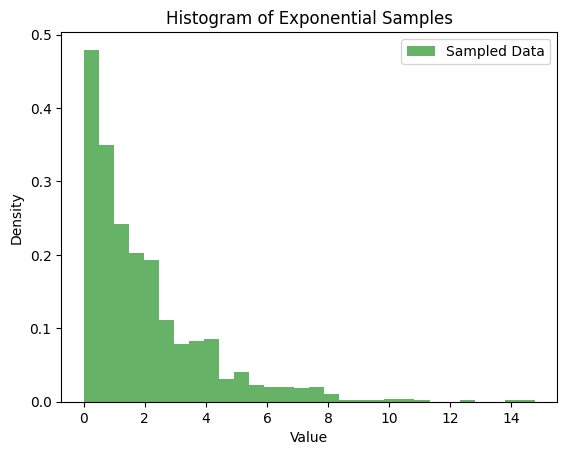

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
lambda_param = 0.5
num_samples = 1000

# Step 1: Generate uniform random samples between 0 and 1
uniform_samples = np.random.uniform(0, 1, num_samples)

# Step 2: Apply the inverse CDF of the exponential distribution
exponential_samples = -2 * np.log(1 - uniform_samples)

# Check the mean of the samples
sample_mean = np.mean(exponential_samples)
theoretical_mean = 1 / lambda_param

print(f'Sample Mean: {sample_mean}')
print(f'Theoretical Mean: {theoretical_mean}')

# Plot the histogram of the samples
plt.hist(exponential_samples, bins=30, density=True, alpha=0.6, color='g', label='Sampled Data')
plt.title('Histogram of Exponential Samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


# The Metropolis algorithm
In this part of the exercise, we will implement one of the basic MCMC algorithms - the Metropolis algorithm. You should have read Kruschke's chapter 7, which gives kind of an intuitive understanding of the algorithm's basic idea. If you are looking for a  more formal treatment, I suggest Gelman et al., chapter 11.

First, we generate some data from a multivariate normal, of which we want to infer the correlation.

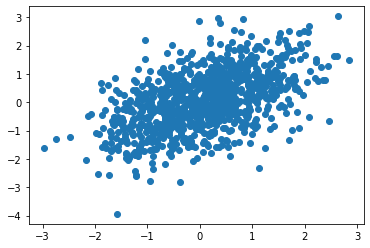

In [4]:
rho = 0.5
n = 1000

def gen_data(rho, n):
    data = np.random.multivariate_normal(mean=np.zeros(2), cov=np.array([[1, rho], [rho, 1]]), size=n)
    x, y = data[:,0], data[:,1]
    return x, y

x, y = gen_data(rho, n)

plt.scatter(x, y)

Before we can start the inference process, we need to define our likelihood and our prior. To avoid numerical instabilities (floating point underflow / overflow), which can arise if we multiply lots of numbers together, we work with log probabilities instead of probabilities. This is a common trick which you will see over and over again.

The equations are given in the exercise sheet. Derive their log and fill out the functions below!

In [7]:
def log_likelihood(x, y, rho):
    # your code here
    ll = ...
    return ll

def log_prior(rho):
    # your code here
    lp = ...
    return lp

def log_post(x, y, rho):
    return log_likelihood(x, y, rho) + log_prior(rho)



Now, we will implement the Metropolis algorithm. As you have seen in your reading materials, it has two main building blocks

### 1. The proposal distribution
The proposal distribution generates a new candidate sample based on your current sample. Here, we will use a uniform distribution between `rho - step` and `rho + step`.

\begin{align}
    \rho^* ~\sim \text{Uniform}(\rho^{(i-1)} - 0.07, \rho^{(i-1)} + 0.07).
\end{align}

We now have to decide whether we move to new new candidate sample $\rho^*$ or stick with our current sample. This defines the way we move through the parameter space with our Markov Chain. We dedice this based on an acceptance probability, which we compute like this

\begin{align}
    \alpha(p^{(i)} | p^{(i-1)}) = \min\left\{1, \frac{p(\rho^{(i)} | x, y)}{p(\rho^{(i-1)} | x, y)}\right\},
\end{align}

where $p(\rho | x, y)$ is our posterior distribution. Can you tell from this equation why we did not need to normalize the posterior distribution?

The intuition behind the acceptance probability is that we want to accept and `keep' more samples in regions with a high posterior probability than in regions with a low posterior probability. Remember, we want to draw samples from the proposal distributions in a way that it mimics drawing samples from the unknown posterior distribution, so more samples from regions with a lot of probability mass is exactly what we need.

Go ahead and implement the two functions. `proposal(rho, step)` should return a single sample from a uniform distribution between `rho` $\pm$ `step`. `acceptance(rho, rho_candidate)` should return the acceptance proability, where `rho_candidate` acts as the next sample and `rho` as the current sample.

In [6]:
def proposal(rho, step=0.07):
    # your code here
    rho_star = ...
    return rho_star

def acceptance(rho, rho_candidate):
    # your code here
    p_acceptance = ...
    return p_acceptance


We now implement the full algorithm, which should not be too hard, since we already have all the essential building blocks. Until we have `n_samples` in our list `rhos`, we iterate:

- generate a new proposal `rho_candidate`
- compute the acceptance probability
- generate a random number between 0 and 1
- if that number is smaller than the acceptance probability, move to the new sample `rho_candidate`
- else, keep the current sample `rho`

Now generate 1,000 samples and visualize the posterior distribution and the Markov Chain!

In [114]:
def metropolis_hastings(x, y, step=0.07, rho_init=0.2, n_samples=1000):
    # initialize empty array
    rhos = []
    # initialize current sample
    rho = rho_init
    
    # while we have not yet collected enough samples
    while len(rhos) < n_samples:
        
        # your code here
            
    return np.array(rhos)

mcmc_samples = metropolis_hastings(x, y)

In [ ]:
plt.plot(mcmc_samples)

plt.figure()
plt.hist(mcmc_samples)

Play around with the hyperparameters of the algorithm (the step size and the initial value). What influence to they have?